In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from evaluation import evaluate_model
from preprocessing import run_feature_engineering

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

c:\Users\Ahmed Osama\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")

test_identity = pd.read_csv(dataset_path / "test_identity.csv")
test_tx = pd.read_csv(dataset_path / "test_transaction.csv")

In [11]:
train_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')
# test = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

X =  train_all_cols.drop(columns=['isFraud'])
y = train_all_cols['isFraud']
X = X.fillna(-999) #* for lightgbm to handl

In [4]:
print(f"X_shape: {X.shape}")

X_shape: (590540, 433)


In [5]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# X[cat_cols] = X[cat_cols].astype('category')

In [12]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

In [13]:
X_train, X_val, X_test = run_feature_engineering(X_train, X_val, X_test)

🚧 Starting feature engineering pipeline...

✅ Transaction amount ratios created
✅ Data cleaned
✅ Rare categories grouped
✅ Categorical columns encoded
✅ Train set processed
✅ Validation set processed
✅ Test set processed
✅ Unused columns dropped

🎯 Final Shapes:
📐 X_train shape: (377945, 430)
📐 X_val shape:   (94487, 430)
📐 X_test shape:  (118108, 430)
🔍 Columns in train but not in test: set()
🔍 Columns in test but not in train: set()


In [14]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [15]:
# Create dataset for LGB
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train, categorical_feature=cat_cols)

In [16]:
# Train
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_val],
    num_boost_round=1000,
)


Validation Metrics:
AUC: 0.9615
Accuracy: 0.9849
Precision: 0.9568
Recall: 0.5956
F1 Score: 0.7342
Log Loss: 0.0537
Brier Score: 0.0127
Average Precision: 0.8141

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91181
           1       0.96      0.60      0.73      3306

    accuracy                           0.98     94487
   macro avg       0.97      0.80      0.86     94487
weighted avg       0.98      0.98      0.98     94487

Confusion Matrix:
[[91092    89]
 [ 1337  1969]]

Test Metrics:
AUC: 0.9630
Accuracy: 0.9835
Precision: 0.9585
Recall: 0.5531
F1 Score: 0.7014
Log Loss: 0.0556
Brier Score: 0.0135
Average Precision: 0.8180

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.96      0.55      0.70      4133

    accuracy                           0.98    118108
   macro avg       0.97      0.78     

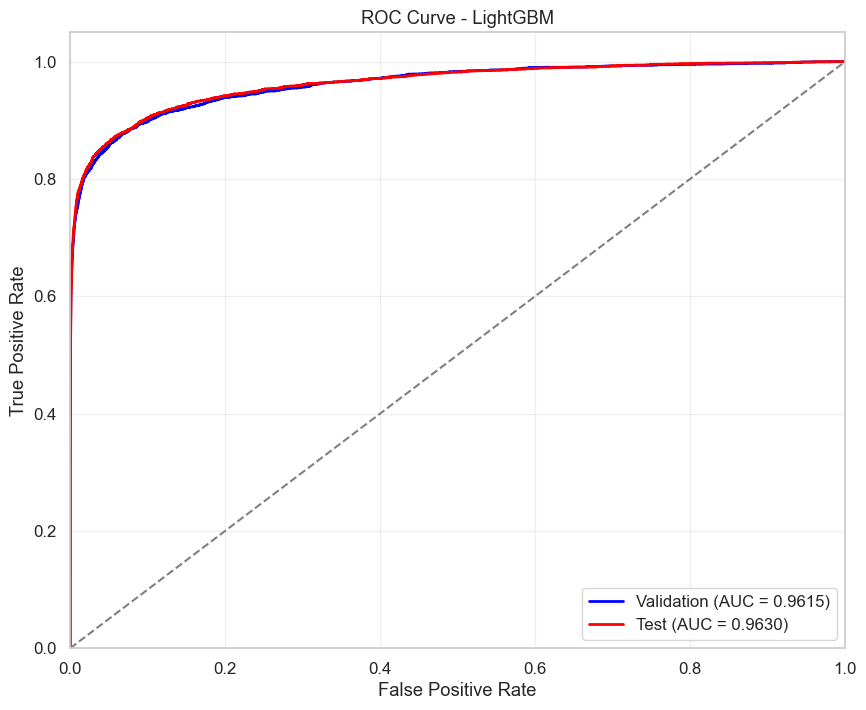

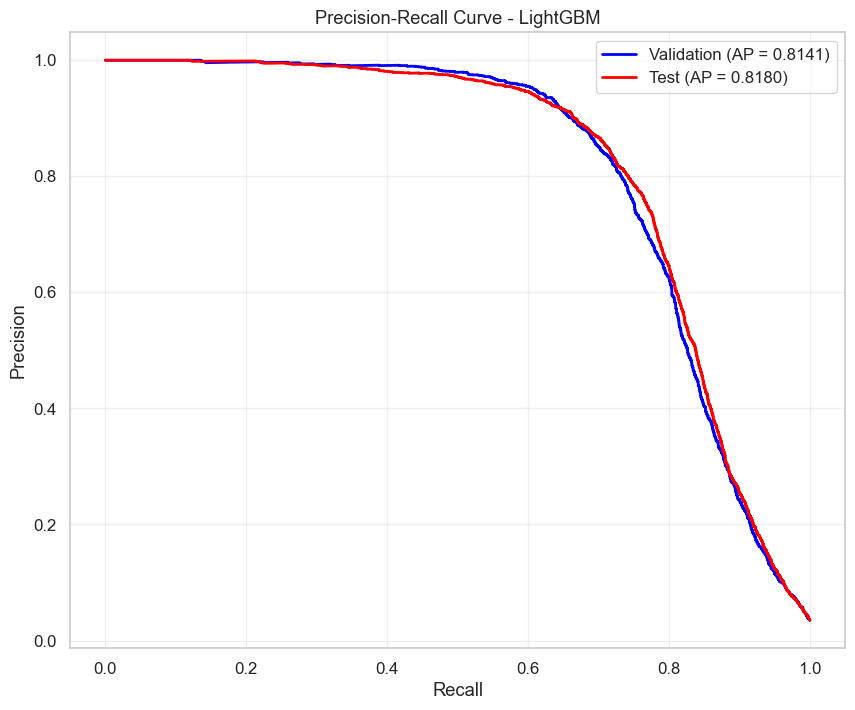

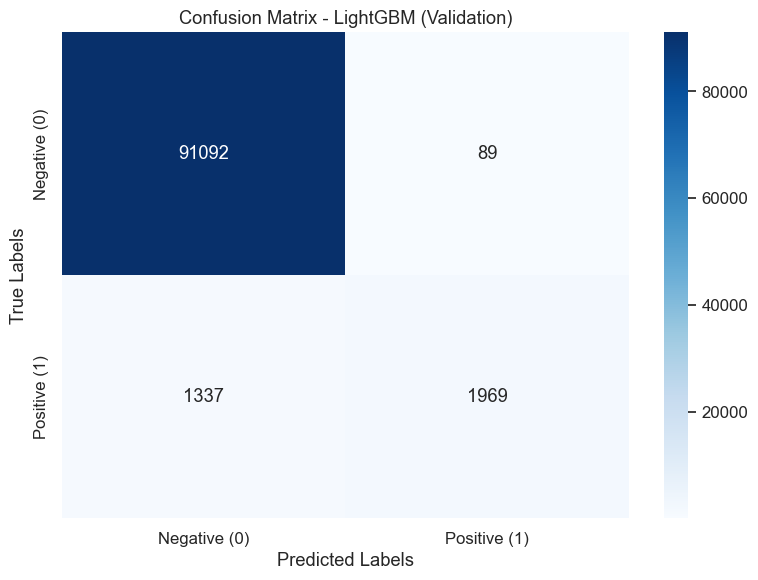

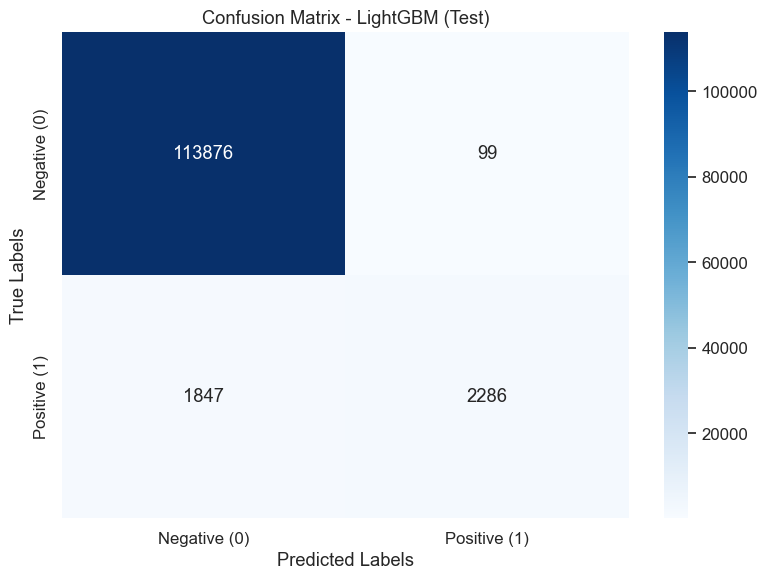

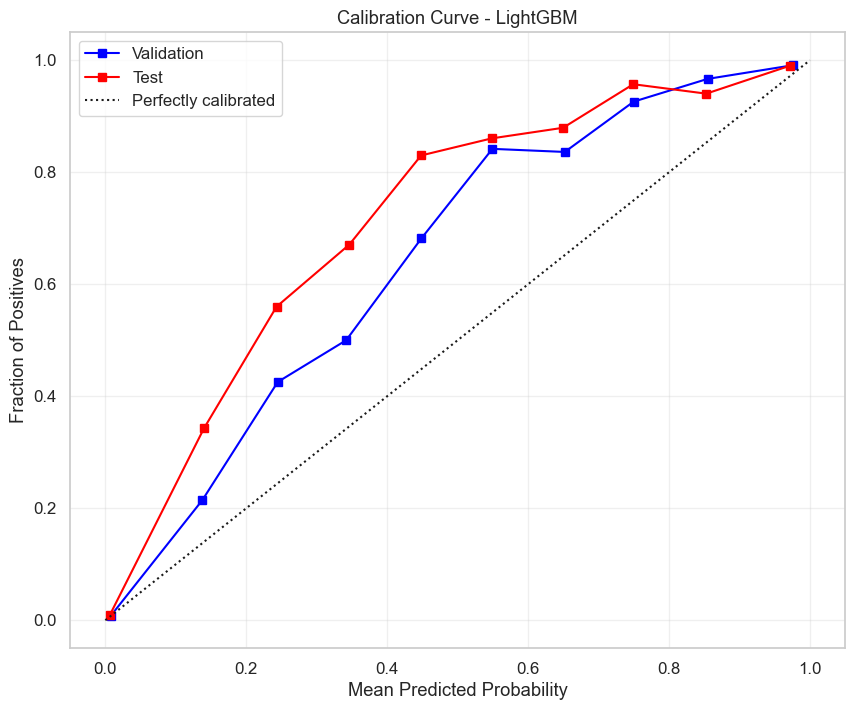

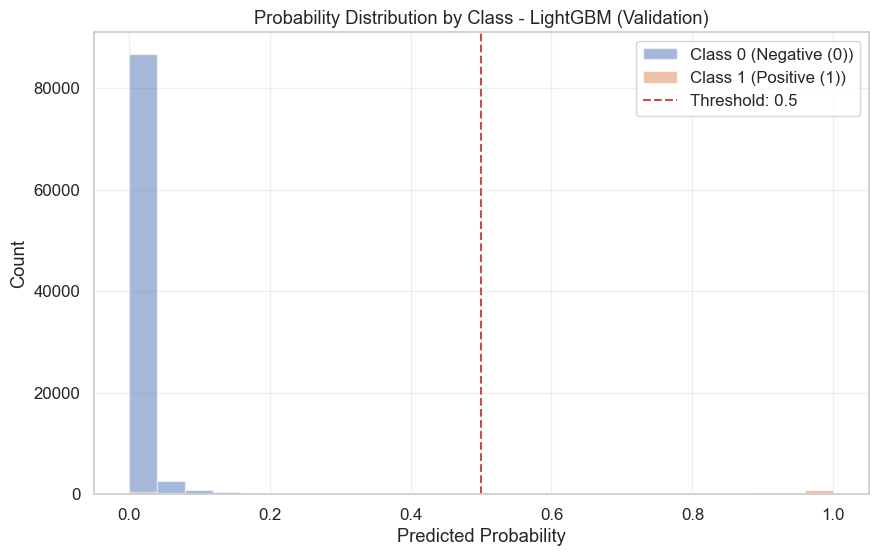

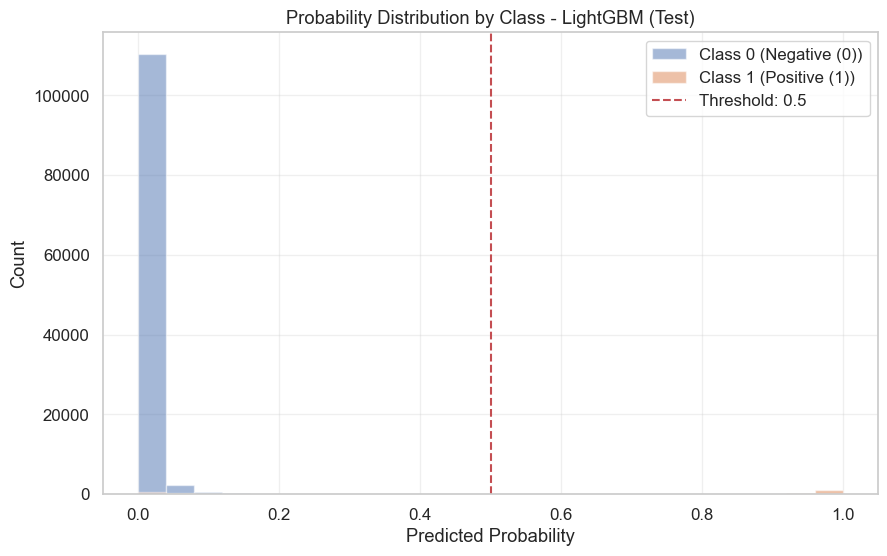

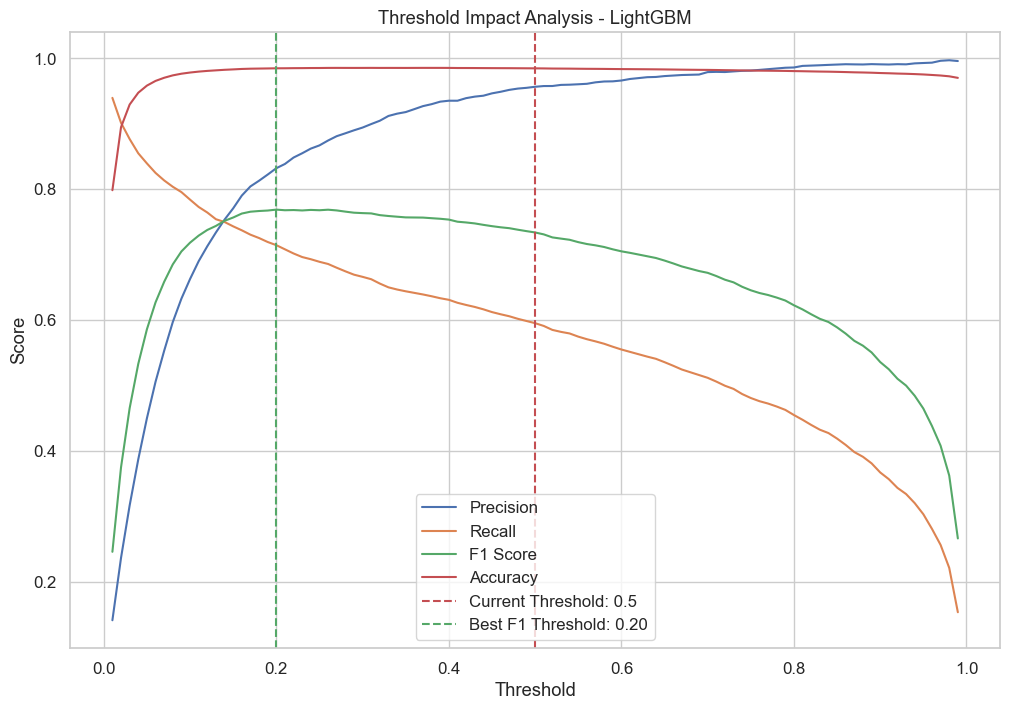

{'validation': {'auc': np.float64(0.9615398709067351),
  'accuracy': 0.9849079767587076,
  'precision': 0.956754130223518,
  'recall': 0.5955837870538415,
  'f1': 0.7341536167039523,
  'log_loss': 0.0536937103725376,
  'brier_score': np.float64(0.012664869460340112),
  'average_precision': np.float64(0.8140999795554192),
  'confusion_matrix': array([[91092,    89],
         [ 1337,  1969]]),
  'classification_report': {'0': {'precision': 0.9855348429605427,
    'recall': 0.9990239194569044,
    'f1-score': 0.9922335384782964,
    'support': 91181.0},
   '1': {'precision': 0.956754130223518,
    'recall': 0.5955837870538415,
    'f1-score': 0.7341536167039523,
    'support': 3306.0},
   'accuracy': 0.9849079767587076,
   'macro avg': {'precision': 0.9711444865920303,
    'recall': 0.7973038532553729,
    'f1-score': 0.8631935775911244,
    'support': 94487.0},
   'weighted avg': {'precision': 0.9845278363214431,
    'recall': 0.9849079767587076,
    'f1-score': 0.9832035955085124,
    '

In [19]:
evaluate_model(
    model,
    X_val,
    y_val,
    X_test,
    y_test,
    threshold=0.5,
    model_name="LightGBM",
    is_lightgbm=True
)